In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

#Set style
sns.set(style="whitegrid")

In [7]:
df=pd.read_csv("Mall_Customers_dataset.csv")

In [69]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [71]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [73]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Text(0.5, 1.0, 'Gender Distribution')

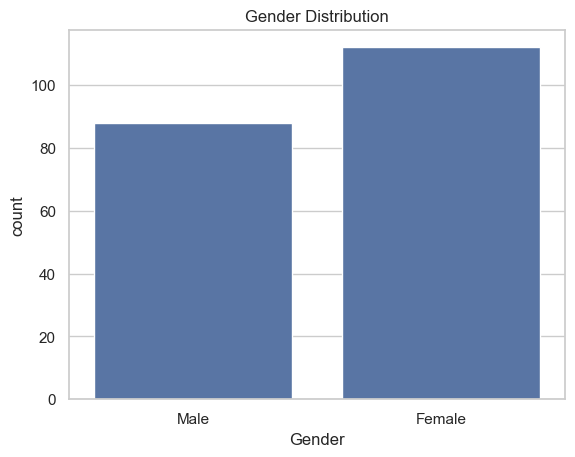

In [131]:
# Gender distribution
sns.countplot(x='Gender', data=df)
plt.title("Gender Distribution")

Text(0.5, 1.0, 'Age Distribution')

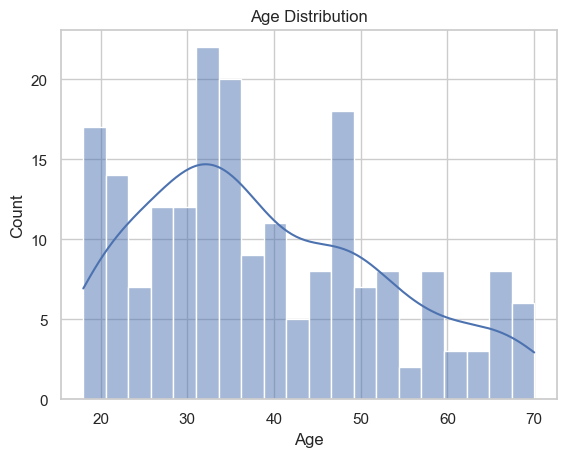

In [129]:
# Distribution of Age
sns.histplot(df['Age'], kde=True, bins=20)
plt.title("Age Distribution")

Text(0.5, 1.0, 'Spending Score vs Annual Income')

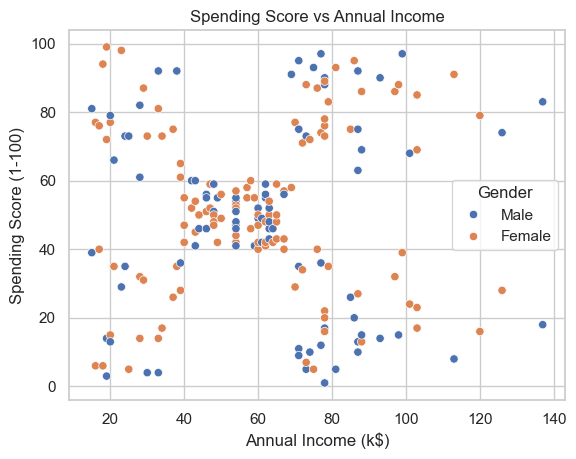

In [53]:
# Spending Score vs Income
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue='Gender')
plt.title("Spending Score vs Annual Income")

In [137]:
df.corr(numeric_only= True)

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Cluster
CustomerID,1.000000,-0.026763,0.977548,0.013835,-0.085724
Age,-0.026763,1.000000,-0.012398,-0.327227,-0.003475
Annual Income (k$),0.977548,-0.012398,1.000000,0.009903,-0.101491
Spending Score (1-100),0.013835,-0.327227,0.009903,1.000000,-0.488733
Cluster,-0.085724,-0.003475,-0.101491,-0.488733,1.000000


In [11]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

In [13]:
scaler= StandardScaler()
X_scaled= scaler.fit_transform(X)

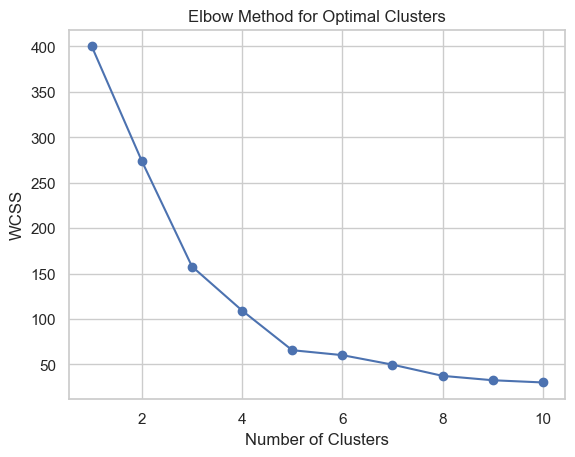

In [23]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()


In [27]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

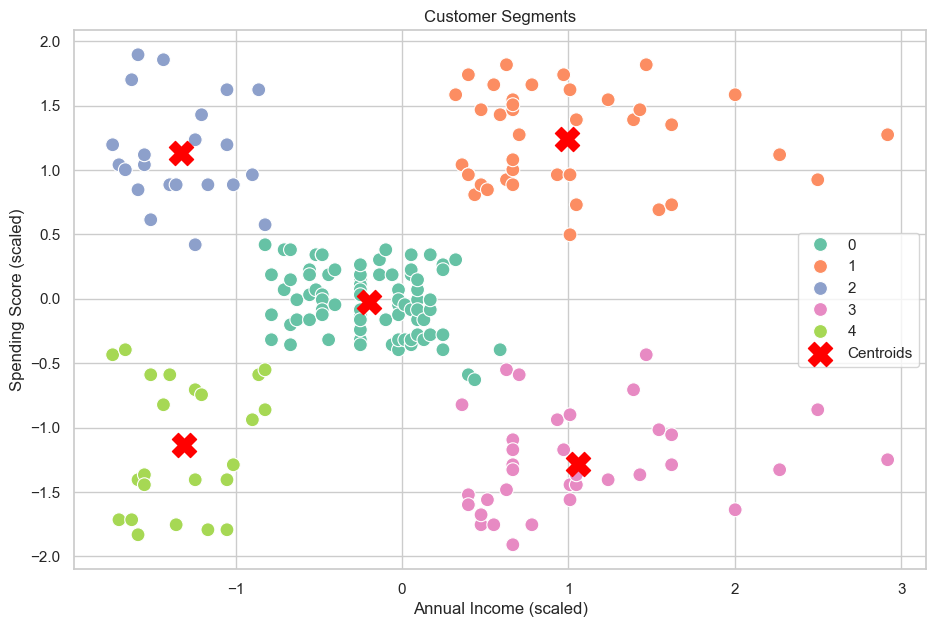

In [31]:
# Visualizing clusters
plt.figure(figsize=(11, 7))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=clusters, palette='Set2', s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids', marker='X')
plt.title("Customer Segments")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.legend()
plt.show()


In [151]:
print("\nCluster Distribution:")
print(df['Cluster'].value_counts())


Cluster Distribution:
Cluster
0    81
1    39
3    35
4    23
2    22
Name: count, dtype: int64


In [149]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.555


In [45]:
#We have already completed the KMeans clustering using 2 features, now we are checking what happens when we increase the number of features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Feature list
features = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Preprocessor for numerical and categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['Gender']),
        ('num', StandardScaler(), ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
    ]
)

# Pipeline: Preprocessing + KMeans
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('clustering', KMeans(n_clusters=5, init='k-means++', random_state=42))
])

# Fit pipeline
pipeline.fit(df[features])

# Get cluster labels
df['Cluster'] = pipeline.named_steps['clustering'].labels_


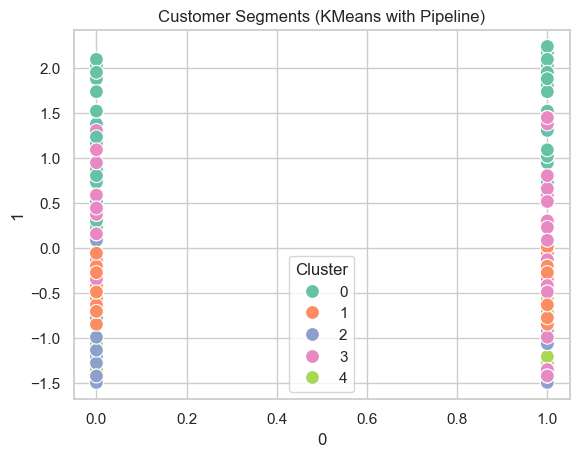

In [47]:
# Preprocess features (only)
X_processed = preprocessor.fit_transform(df[features])

# For 2D visualization
X_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed)

# Append cluster
X_df['Cluster'] = df['Cluster']

# Plot clusters
sns.scatterplot(data=X_df, x=0, y=1, hue='Cluster', palette='Set2', s=100)
plt.title("Customer Segments (KMeans with Pipeline)")
plt.show()


In [49]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

# Range of clusters to try
param_grid = {'clustering__n_clusters': range(2, 11)}

# Manual grid search
best_score = -1
best_k = None
best_model = None

for params in ParameterGrid(param_grid):
    pipeline.set_params(**params)
    pipeline.fit(df[features])
    preds = pipeline.named_steps['clustering'].labels_
    score = silhouette_score(preprocessor.transform(df[features]), preds)
    print(f"Clusters: {params['clustering__n_clusters']} -> Silhouette Score: {score:.3f}")
    
    if score > best_score:
        best_score = score
        best_k = params['clustering__n_clusters']
        best_model = pipeline

print(f"\n✅ Best K: {best_k} with Silhouette Score: {best_score:.3f}")


Clusters: 2 -> Silhouette Score: 0.303
Clusters: 3 -> Silhouette Score: 0.312
Clusters: 4 -> Silhouette Score: 0.350
Clusters: 5 -> Silhouette Score: 0.350
Clusters: 6 -> Silhouette Score: 0.356
Clusters: 7 -> Silhouette Score: 0.332
Clusters: 8 -> Silhouette Score: 0.336
Clusters: 9 -> Silhouette Score: 0.312
Clusters: 10 -> Silhouette Score: 0.309

✅ Best K: 6 with Silhouette Score: 0.356


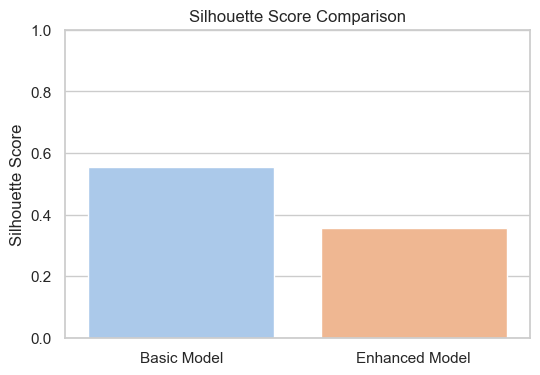

In [61]:
#On comparing the Silhouette Score we conclude that when we used less features(i.e 2) then our model performed better.
score_basic=0.555
score_enhanced=0.356
plt.figure(figsize=(6,4))
scores = [score_basic, score_enhanced]
labels = ['Basic Model', 'Enhanced Model']
sns.barplot(x=labels, y=scores, palette='pastel')
plt.title("Silhouette Score Comparison")
plt.ylabel("Silhouette Score")
plt.ylim(0, 1)
plt.show()